## **Importing files and libraries**

### Libraries

In [39]:
# For Data
import os
#import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#from datetime import datetime
from scipy import  fftpack
#from re import split
import statistics

# Graphics
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import style
from mpl_toolkits.mplot3d import axes3d

# Distributions
#from scipy import stats
#import inspect
#from statsmodels.distributions.empirical_distribution import ECDF

# matplotlib Settings
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# warnings Settings
import warnings
warnings.filterwarnings('ignore')


#Others
from IPython.display import Image
#import numpy as np
#import scipy.fftpack as fourier
#import matplotlib.pyplot as plt
#import scipy.io.wavfile as waves

### Files

#### Load

In [3]:
# Verificar el directorio actual
print("Directorio actual:", os.getcwd())

# Cambiar al directorio superior (bajar un nivel)
os.chdir('../..')

# Verificar el nuevo directorio
print("Nuevo directorio actual:", os.getcwd())

Directorio actual: d:\lenovo\Documents\GitHub\Energy-and-linear-momentum-change-exerted-by-the-solar-wind-for-applications-in-electric-solar-sails-main\Codes\Past
Nuevo directorio actual: d:\lenovo\Documents\GitHub\Energy-and-linear-momentum-change-exerted-by-the-solar-wind-for-applications-in-electric-solar-sails-main


In [4]:
#Function for simply the files load
def dir(r_or_p, year):
    rp = ("Raw", "Calibrated",)
    r_or_p = r_or_p.strip().capitalize()
    if r_or_p not in rp: #Validate data
        raise NameError("Only Raw or Processed")

    if r_or_p == rp[0]:
      dir = f"Data/Raw_converter/{year}.parquet"
      return dir

    else:
      dir = f"Data/Processing_converter/{year}.parquet"

      return dir



In [5]:
#Years that have a analysis
i_year = 1998
f_year = 2023
step_year = 5
other_year = 2000

years = [year for year in range(i_year, f_year + step_year, step_year)] #+ [other_year]

years.sort()

years

[1998, 2003, 2008, 2013, 2018, 2023]

#### Raw data

In [6]:
Raw_data = {}
for year in years:
  Raw_data[year] = pd.read_parquet(dir("Raw",year))


Raw_data

{1998:         YY  MON  DY  DOY:HH:MM:SS     Seconds  SPEED     Np  Vth  N/S  V_He  \
 0       98  Jan   1  001:00:00:30        30.0    361  10.08   32 -0.5   370   
 1       98  Jan   1  001:00:01:00        60.0    358  10.21   31  0.0   366   
 2       98  Jan   1  001:00:01:30        90.0    362  10.08   32 -0.0   371   
 3       98  Jan   1  001:00:02:00       120.0    360  10.09   32 -0.3   369   
 4       98  Jan   1  001:00:02:30       150.0    358  10.71   30 -0.7   366   
 ...     ..  ...  ..           ...         ...    ...    ...  ...  ...   ...   
 619716  98  Dec  21  355:17:27:16  30648436.0    318  13.51   23  5.3   320   
 619717  98  Dec  21  355:17:27:46  30648466.0    317  13.47   23  5.1   320   
 619718  98  Dec  21  355:17:28:16  30648496.0    319  13.08   23  5.1   322   
 619719  98  Dec  21  355:17:28:46  30648526.0    319  11.60   23  5.0   322   
 619720  98  Dec  21  355:17:29:16  30648556.0    324  10.40   23  4.5   327   
 
         GSE_X  GSE_Y  GSE_Z  RA

#### Processed/ Calibrated data

In [7]:
Calibrated_data = {}
for year in years:
  Calibrated_data[year] = pd.read_parquet(dir("Calibrated",year))


Calibrated_data

{1998:        YY  MON  DY  DOY:HH:MM:SS     Seconds  SPEED     Np  Vth  N/S  V_He  \
 0      98  Jan   1  001:00:05:02       302.0    371  10.08   35 -0.8   383   
 1      98  Jan   1  001:00:10:03       603.0    371   9.80   35 -0.9   383   
 2      98  Jan   1  001:00:15:05       905.0    370   9.00   36  0.3   383   
 3      98  Jan   1  001:00:20:11      1211.0    372   7.25   38  1.5   387   
 4      98  Jan   1  001:00:25:10      1510.0    370   8.36   37  0.3   384   
 ...    ..  ...  ..           ...         ...    ...    ...  ...  ...   ...   
 62155  98  Dec  21  355:17:07:38  30647258.0    336  15.01   24  5.6   338   
 62156  98  Dec  21  355:17:12:39  30647559.0    332  14.50   23  3.8   335   
 62157  98  Dec  21  355:17:17:41  30647861.0    334  13.97   24  3.9   337   
 62158  98  Dec  21  355:17:22:43  30648163.0    334  14.58   23  4.7   337   
 62159  98  Dec  21  355:17:27:46  30648466.0    333  13.76   23  4.9   335   
 
        GSE_X  GSE_Y  GSE_Z  RANGE  HGLAT  H

# Code

In [41]:
def find_best_cutoff_frequency(year, column, cutoff_frequencies, filter_func):
    """
    Finds the best cutoff frequency for a high-pass filter using error metrics.
    
    :param year: Year of the data.
    :param column: Column of the signal.
    :param cutoff_frequencies: List of cutoff frequencies to test (Hz).
    :return: The optimal cutoff frequency and the corresponding metrics.
    """
    data_sheet = Raw_data[year][column]
    calibrated_sheet = Calibrated_data[year][column]
    time_raw = Raw_data[year]["Seconds"]
    time_calibrated = Calibrated_data[year]["Seconds"]

    # Common times between raw and calibrated data
    common_time = np.intersect1d(time_raw, time_calibrated)
    idx_raw_common = np.where(np.isin(time_raw, common_time))[0]
    idx_calibrated_common = np.where(np.isin(time_calibrated, common_time))[0]

    mse_errors, mae_errors, r2_scores = [], [], []

    for cutoff_frequency in cutoff_frequencies:
        filtered_data, freqs, fft_signal, filtered_fft_signal = filter_func(data_sheet, time_raw, cutoff_frequency)

        # Calculate error metrics on common values
        mse = mean_squared_error(calibrated_sheet.iloc[idx_calibrated_common], filtered_data[idx_raw_common])
        mae = mean_absolute_error(calibrated_sheet.iloc[idx_calibrated_common], filtered_data[idx_raw_common])
        r2 = r2_score(calibrated_sheet.iloc[idx_calibrated_common], filtered_data[idx_raw_common])

        mse_errors.append(mse)
        mae_errors.append(mae)
        r2_scores.append(r2)

    # Find the optimal cutoff frequency based on each metric
    min_mse_index = np.where(mse_errors == np.min(mse_errors))[0][-1]
    min_mae_index = np.where(mae_errors == np.min(mae_errors))[0][-1]
    max_r2_index = np.where(r2_scores == np.max(r2_scores))[0][-1]

    print(f"The maximum R^2 is {r2_scores[max_r2_index]} for {cutoff_frequencies[max_r2_index]} Hz")
    print(f"The minimum MSE is {mse_errors[min_mse_index]} for {cutoff_frequencies[min_mse_index]} Hz")
    print(f"The minimum MAE is {mae_errors[min_mae_index]} for {cutoff_frequencies[min_mae_index]} Hz")

    # Plot error metrics
    plt.figure(figsize=(16, 8))
    plt.plot(cutoff_frequencies, mse_errors, label='MSE')
    plt.plot(cutoff_frequencies, mae_errors, label='MAE')
    plt.plot(cutoff_frequencies, r2_scores, label='R²')
    plt.xlabel('Cutoff Frequency')
    plt.ylabel('Error')
    plt.yscale("symlog")
    plt.legend()
    plt.title(f'Error vs Cutoff for {column}')
    plt.show()

    return cutoff_frequencies[min_mse_index], cutoff_frequencies[min_mae_index], cutoff_frequencies[max_r2_index]

## **High Pass Fourier Filter** 

In [32]:
def high_pass_filter(signal, time, cutoff_frequency):
    """
    Applies a high-pass filter in the Fourier domain to the signal.
    
    :param signal: Signal to filter.
    :param time: Time corresponding to each signal point.
    :param cutoff_frequency: Cutoff frequency in Hz.
    :return: Filtered signal.
    """
    # FFT of the signal
    fft_signal = np.fft.fft(signal)
    n = len(signal)
    freqs = np.fft.fftfreq(n, d=(np.max(time) - np.min(time)) / n)

    # Apply high-pass filter
    filter_mask = np.abs(freqs) >= cutoff_frequency
    filtered_fft_signal = fft_signal * filter_mask
    filtered_signal = np.fft.ifft(filtered_fft_signal).real  # Filtered signal in the time domain

    return filtered_signal, freqs, np.sqrt((np.abs(fft_signal)**2)), np.sqrt((np.abs(filtered_fft_signal)**2))

The maximum R^2 is 0.970274971764356 for -0.00016064725193234639 Hz
The minimum MSE is 449.27072749593316 for -0.00016064725193234639 Hz
The minimum MAE is 16.089766750172178 for -0.00016064725193234639 Hz


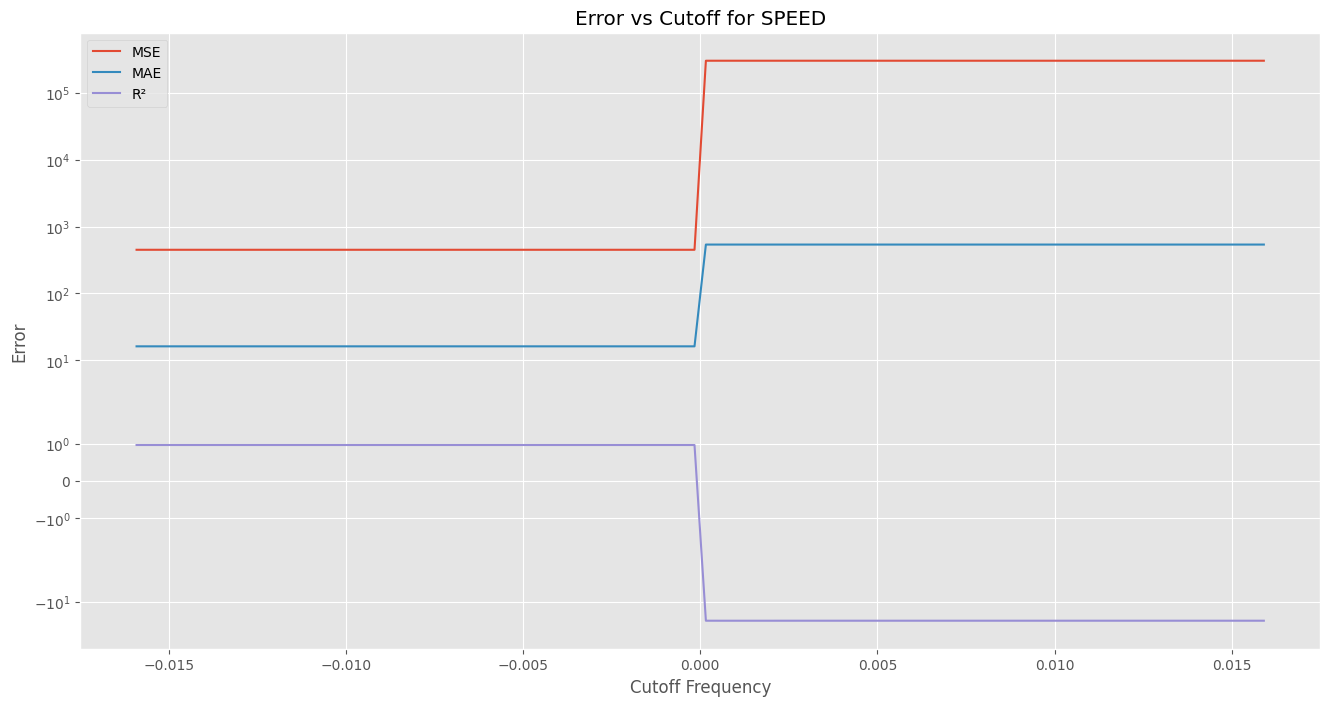

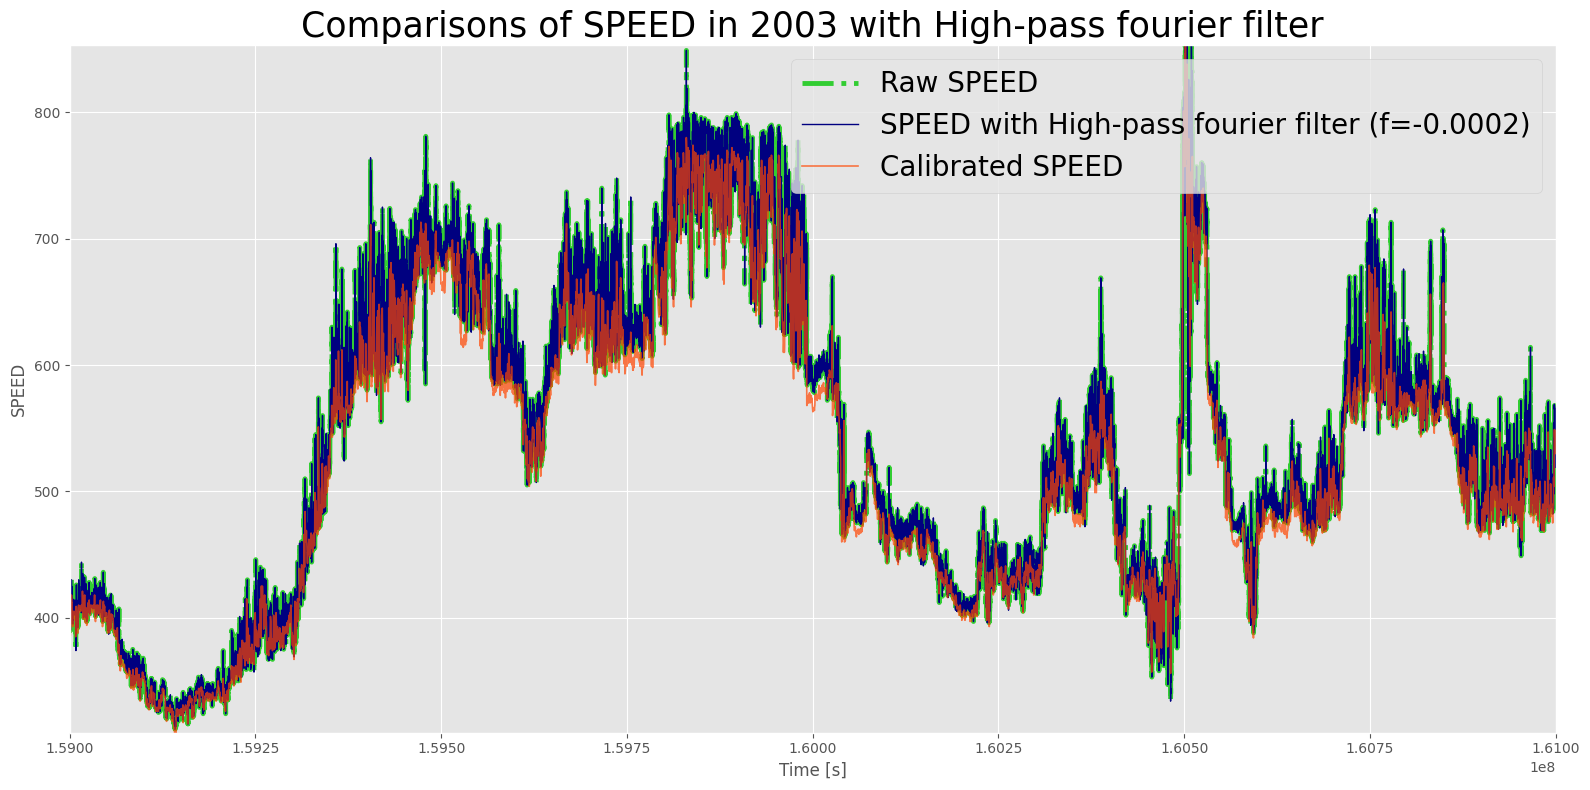

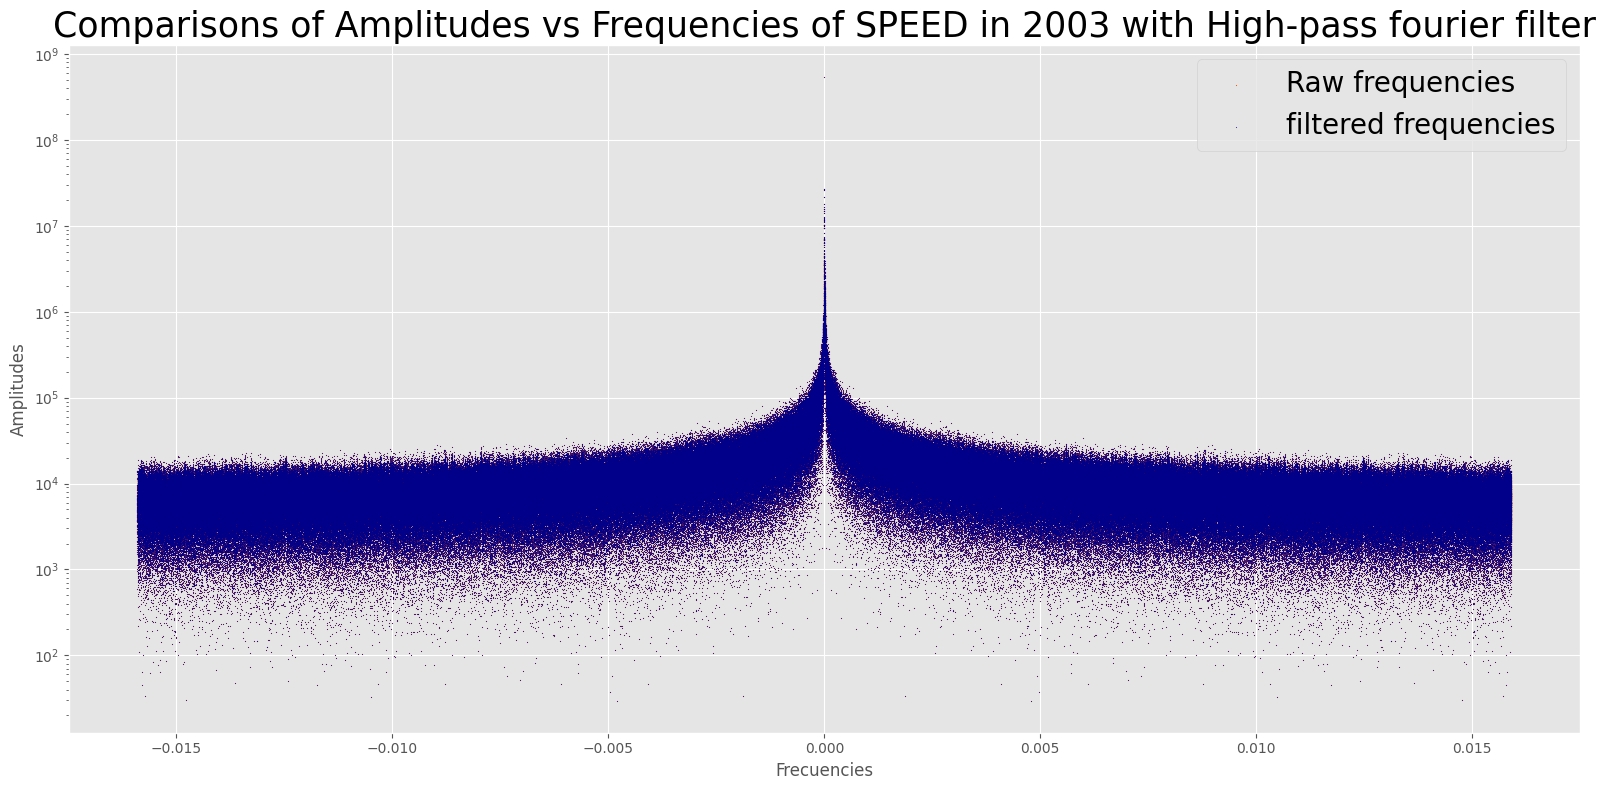

The maximum R^2 is 0.8918096634604777 for -0.00016064725193234639 Hz
The minimum MSE is 1.6998225105546296 for -0.00016064725193234639 Hz
The minimum MAE is 0.804628467058577 for -0.00016064725193234639 Hz


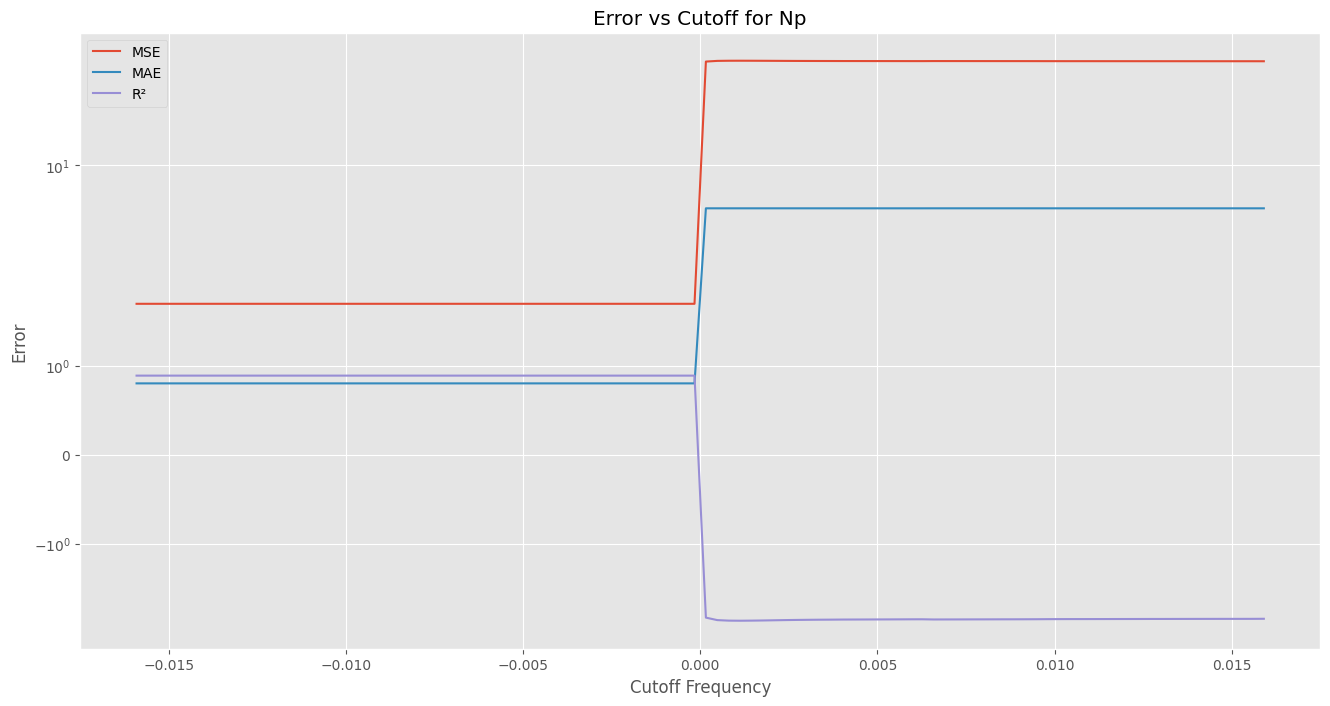

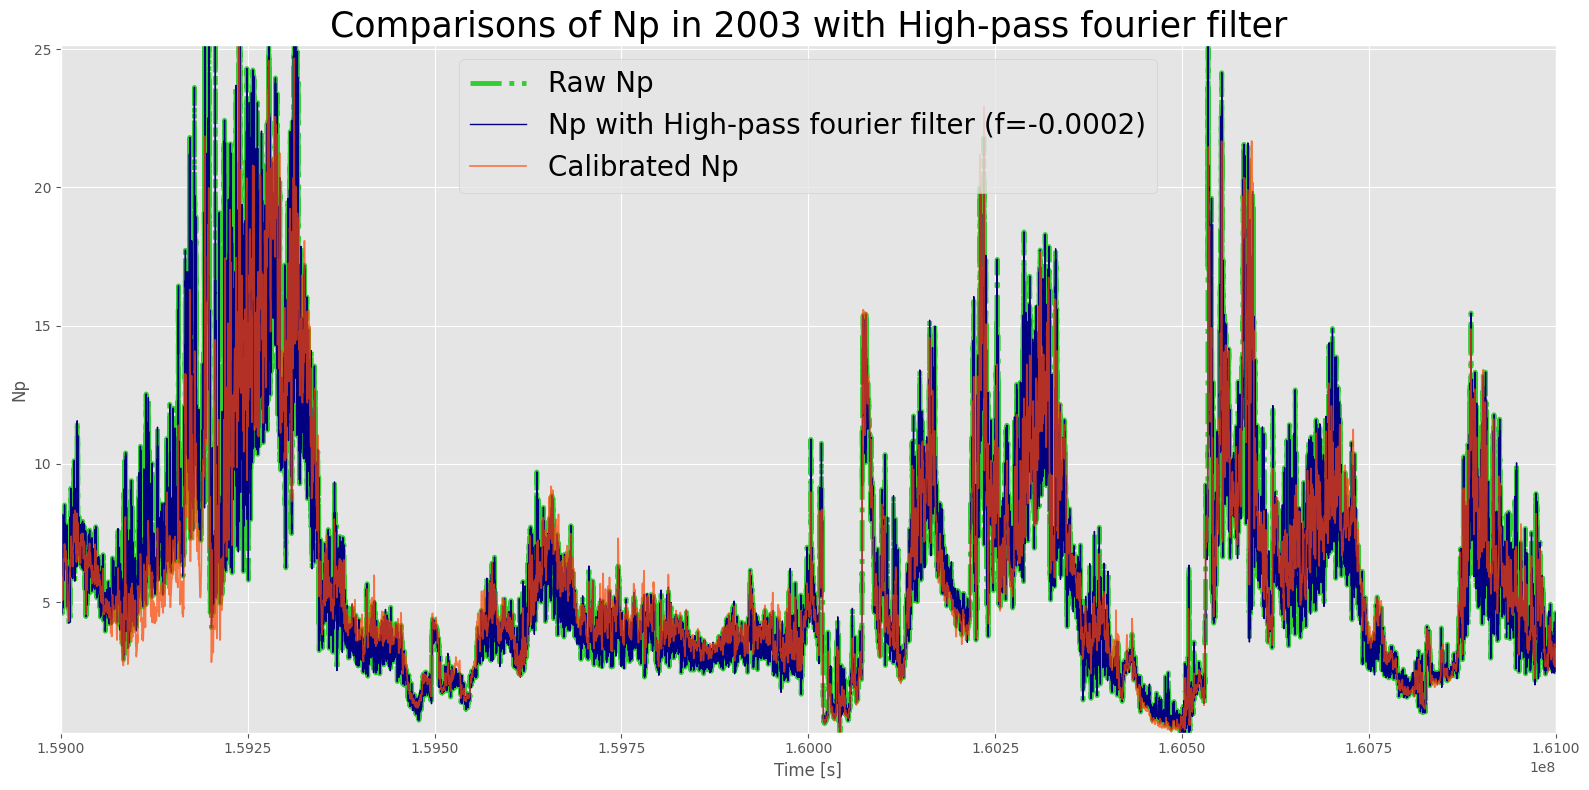

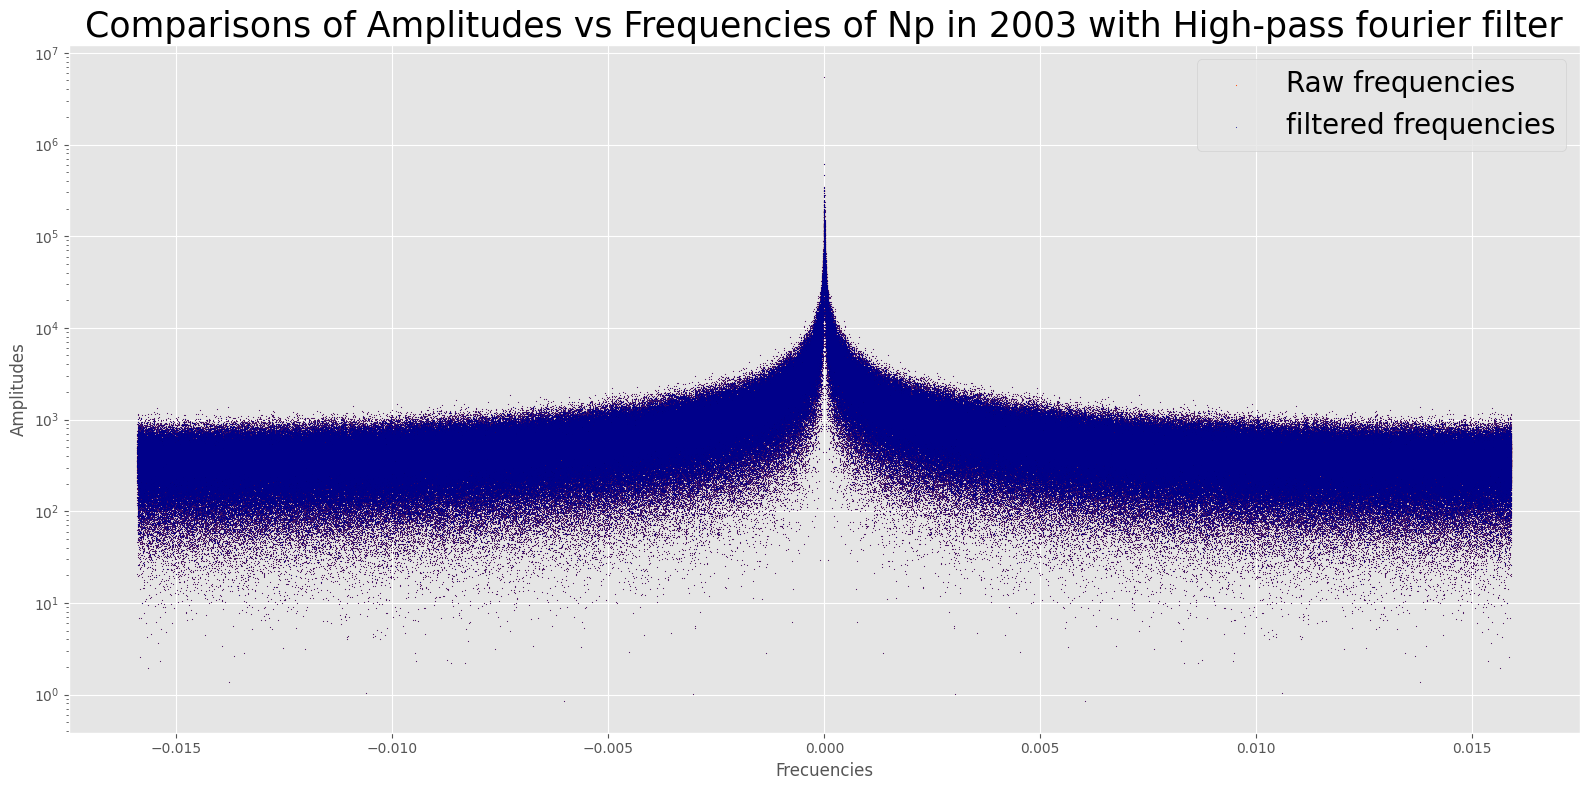

The maximum R^2 is -0.02002755442360371 for 0.01590407794130233 Hz
The minimum MSE is 3.7258631549167305 for 0.01590407794130233 Hz
The minimum MAE is 0.6334264868803213 for -0.00016064725193234639 Hz


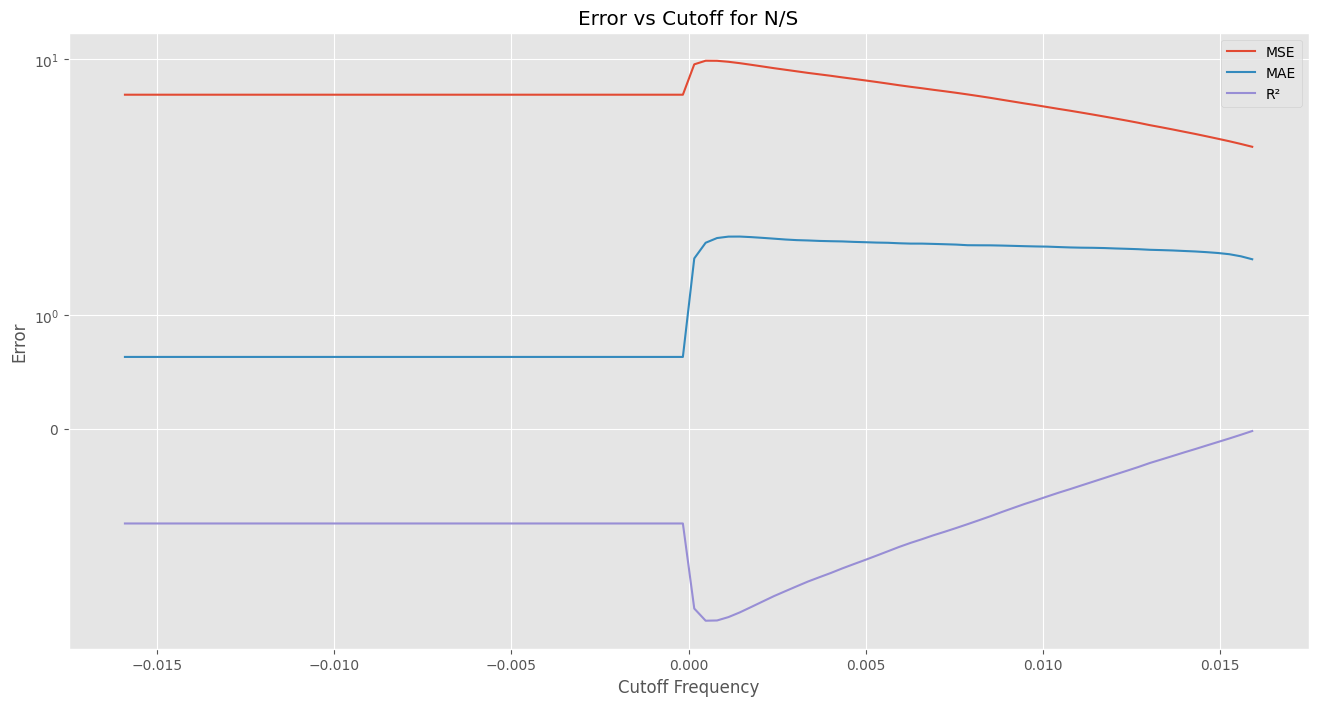

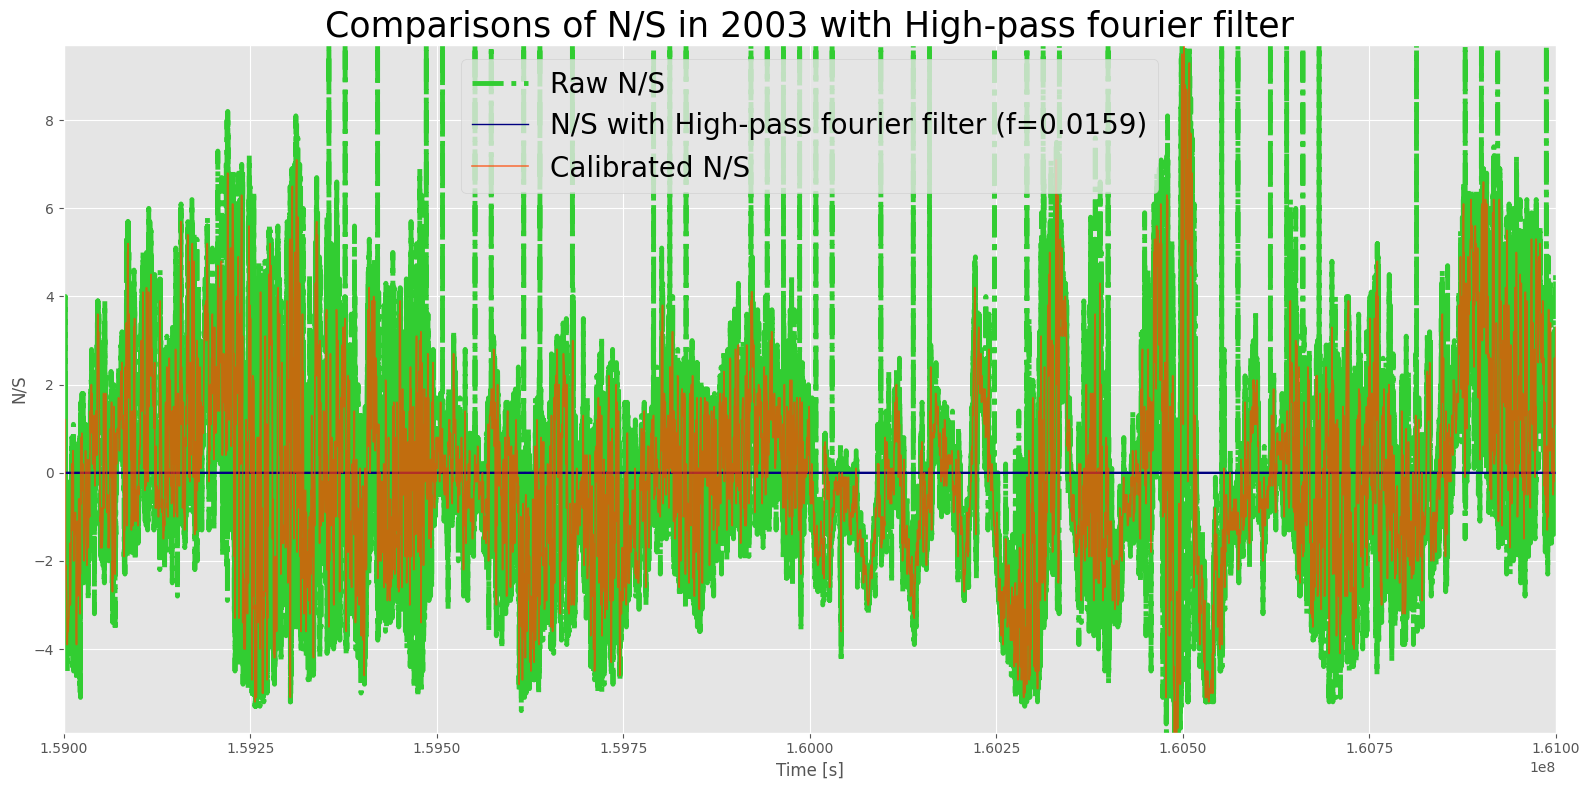

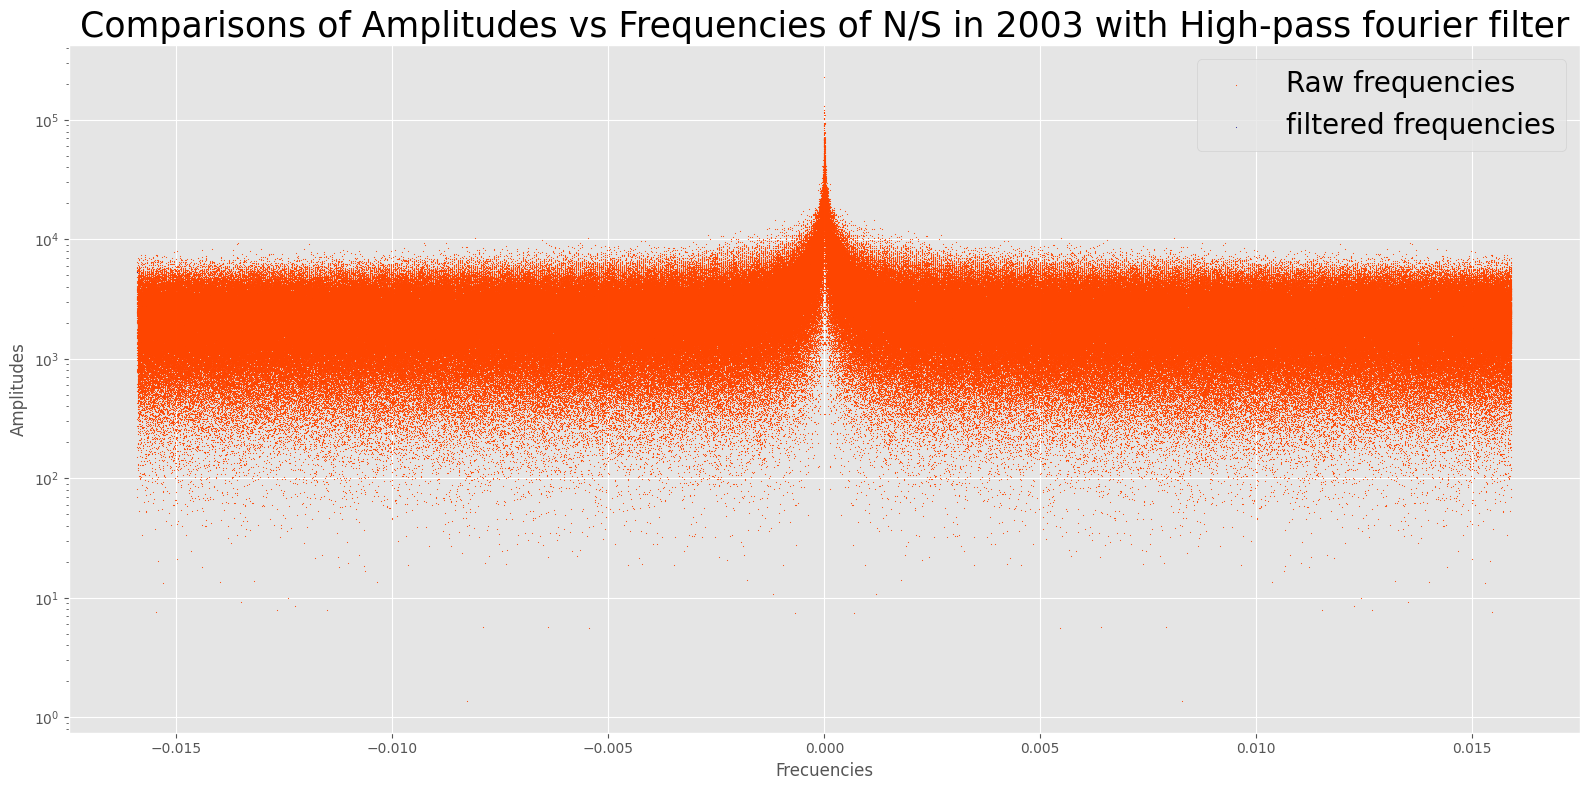

In [48]:
columns = ["SPEED", "Np", "N/S"]

for year in [2003]:
    for column in columns:
        # Calculate the sampling frequency and define the range of cutoff frequencies
        time = Raw_data[year]["Seconds"]
        
        fs = len(time)/(2*(np.max(time)-np.min(time)))

        # Define a range of cutoff frequencies to test
        cutoff_frequencies = np.linspace(-fs, +fs, num=100)
        # Find the best cutoff frequency
        optimal_cutoffs = statistics.mode(find_best_cutoff_frequency(year, column, cutoff_frequencies, high_pass_filter))

        # Plot the original signal and the filtered signal for each optimal frequency
        plt.figure(figsize=(16, 8))
        plt.plot(Raw_data[year]["Seconds"], Raw_data[year][column], label=f'Raw {column}', color="limegreen", linewidth=3.5, linestyle="-.")
        for f in [optimal_cutoffs]:
            filtered_signal, freqs, fft_signal, filtered_fft_signal = high_pass_filter(Raw_data[year][column], Raw_data[year]["Seconds"], f)
            plt.plot(Raw_data[year]["Seconds"], filtered_signal, label=f'{column} with High-pass fourier filter (f={f:.4f})', color="navy", linewidth=1, linestyle="-")
        plt.plot(Calibrated_data[year]["Seconds"], Calibrated_data[year][column], label=f'Calibrated {column}', color="orangered", linewidth=1.2, linestyle="-", alpha=0.7)
        plt.title(f'Comparisons of {column} in {year} with High-pass fourier filter', fontsize=25)
        plt.xlabel('Time [s]')
        plt.ylabel(column)

        # Valores objetivo
        tmin = 1.59e8 
        tmax = 1.61e8
        # Encuentra los índices de los valores en `x` más cercanos a los objetivos
        idx_t_min = np.argmin(np.abs(Calibrated_data[year]["Seconds"] - tmin))
        idx_t_max = np.argmin(np.abs(Calibrated_data[year]["Seconds"] - tmax))
        # Asegura que index1 sea menor que index2 para definir correctamente el rango
        start_idx, end_idx = sorted((idx_t_min, idx_t_max))
        # Encuentra el mínimo y el máximo en el rango de `z` especificado por `start_index` y `end_index`
        y_min = np.min(Calibrated_data[year][column][start_idx:end_idx + 1])
        y_max = np.max(Calibrated_data[year][column][start_idx:end_idx + 1])

        plt.xlim(tmin, tmax)
        plt.ylim(y_min, y_max)
        plt.legend(fontsize=20)
        plt.tight_layout()
        plt.show()

        # Plot the original signal and the filtered signal for each optimal frequency
        plt.figure(figsize=(16, 8))
        for f in [optimal_cutoffs]:
            filtered_signal, freqs, fft_signal, filtered_fft_signal = high_pass_filter(Raw_data[year][column], Raw_data[year]["Seconds"], f)
            plt.scatter(freqs, np.abs(fft_signal.real), label=f'Raw frequencies', s=1e-1, c="orangered")
            plt.scatter(freqs, np.abs(filtered_fft_signal.real), label=f'filtered frequencies', s=1e-1, alpha=0.75, c="darkblue")
        plt.title(f'Comparisons of Amplitudes vs Frequencies of {column} in {year} with High-pass fourier filter', fontsize=25)
        plt.xlabel('Frecuencies')
        plt.ylabel("Amplitudes")
        plt.yscale("log")
        plt.legend(fontsize=20)
        plt.tight_layout()
        plt.show()

## **High Pass Amplitude Fourier Filter** 

In [30]:
def high_pass_amplitude_fourier_filter(signal, time, cutoff_amplitude):
  """
  Applies a high-pass filter in the amplitude Fourier domain to the signal.
  
  :param signal: Signal to filter.
  :param time: Time corresponding to each signal point.
  :param cutoff_amplitude: Cutoff amplitude.
  :return: Filtered signal.
  """
  # FFT of the signal
  fft_signal = np.fft.fft(signal)
  n = len(signal)
  freqs = np.fft.fftfreq(n, d=(np.max(time) - np.min(time)) / n)

  # Apply high-pass filter
  filter_mask = np.sqrt((np.abs(fft_signal**2))) >= cutoff_amplitude
  filtered_fft_signal = fft_signal * filter_mask
  filtered_signal = np.fft.ifft(filtered_fft_signal).real  # Filtered signal in the time domain

  return filtered_signal, freqs, np.sqrt((np.abs(fft_signal)**2)), np.sqrt((np.abs(filtered_fft_signal)**2))

The maximum R^2 is 0.970274971764356 for 29.032076211287436 Hz
The minimum MSE is 449.27072749593316 for 29.032076211287436 Hz
The minimum MAE is 16.089766750172178 for 29.032076211287436 Hz


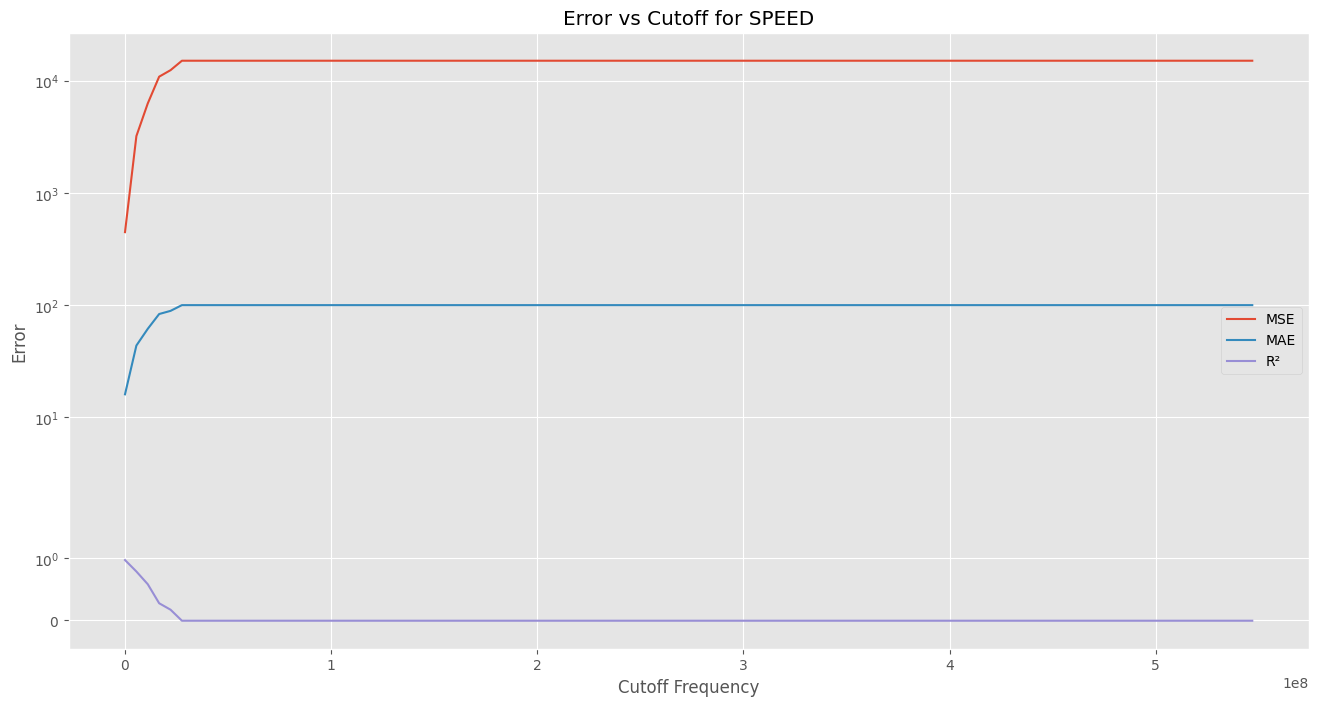

29.032076211287436


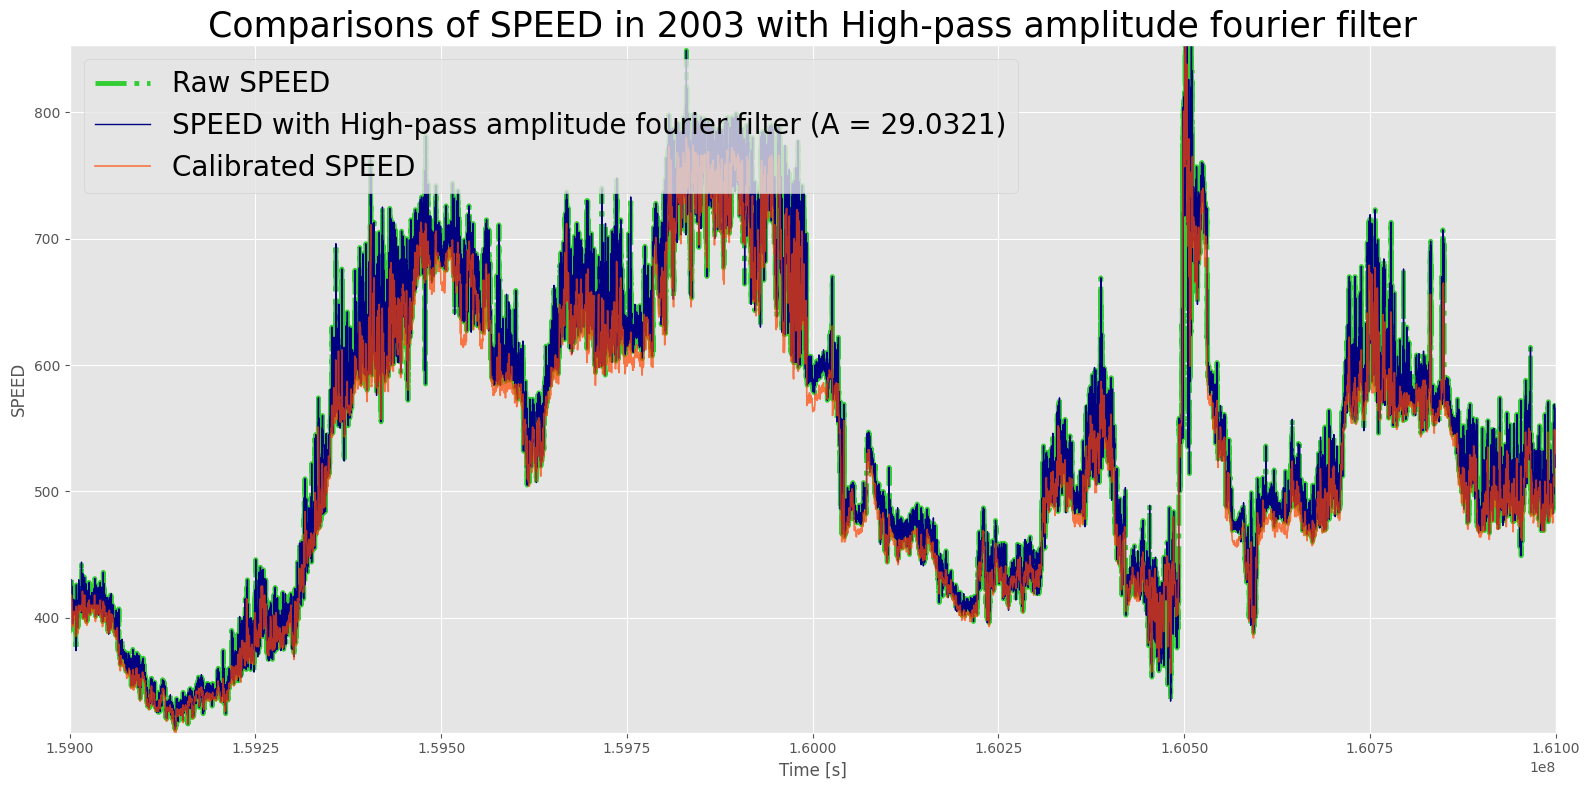

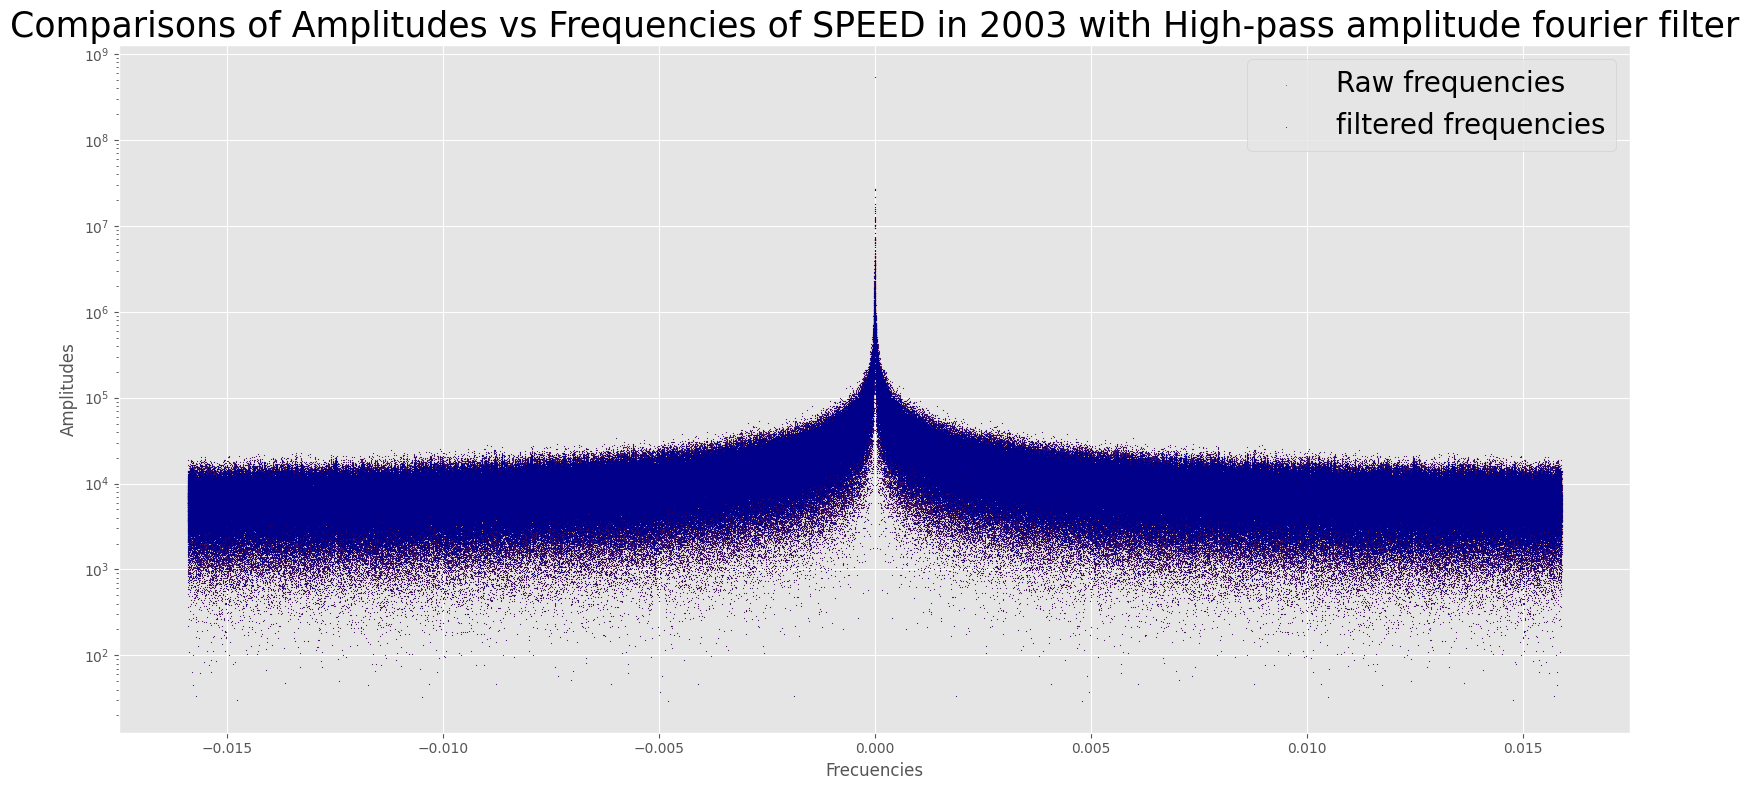

The maximum R^2 is 0.8918096636062552 for 0.8416870838406206 Hz
The minimum MSE is 1.6998225082642602 for 0.8416870838406206 Hz
The minimum MAE is 0.8046284687868037 for 0.8416870838406206 Hz


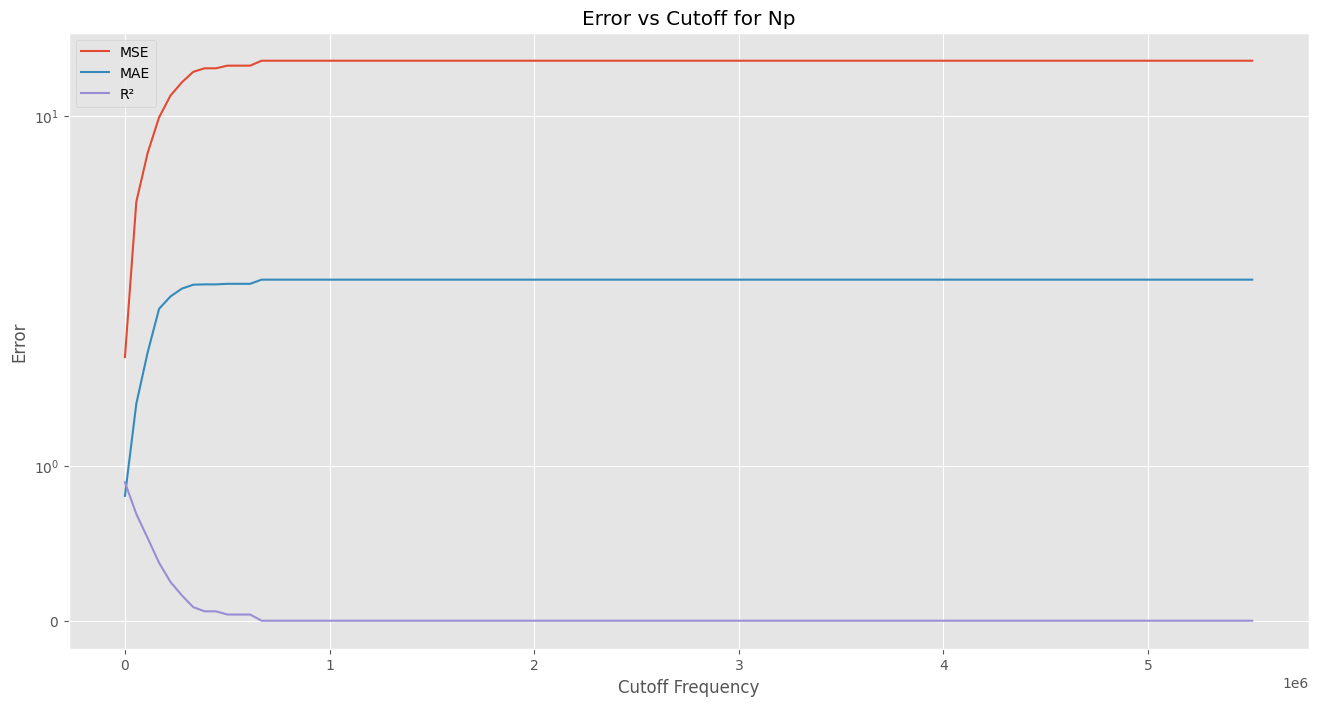

0.8416870838406206


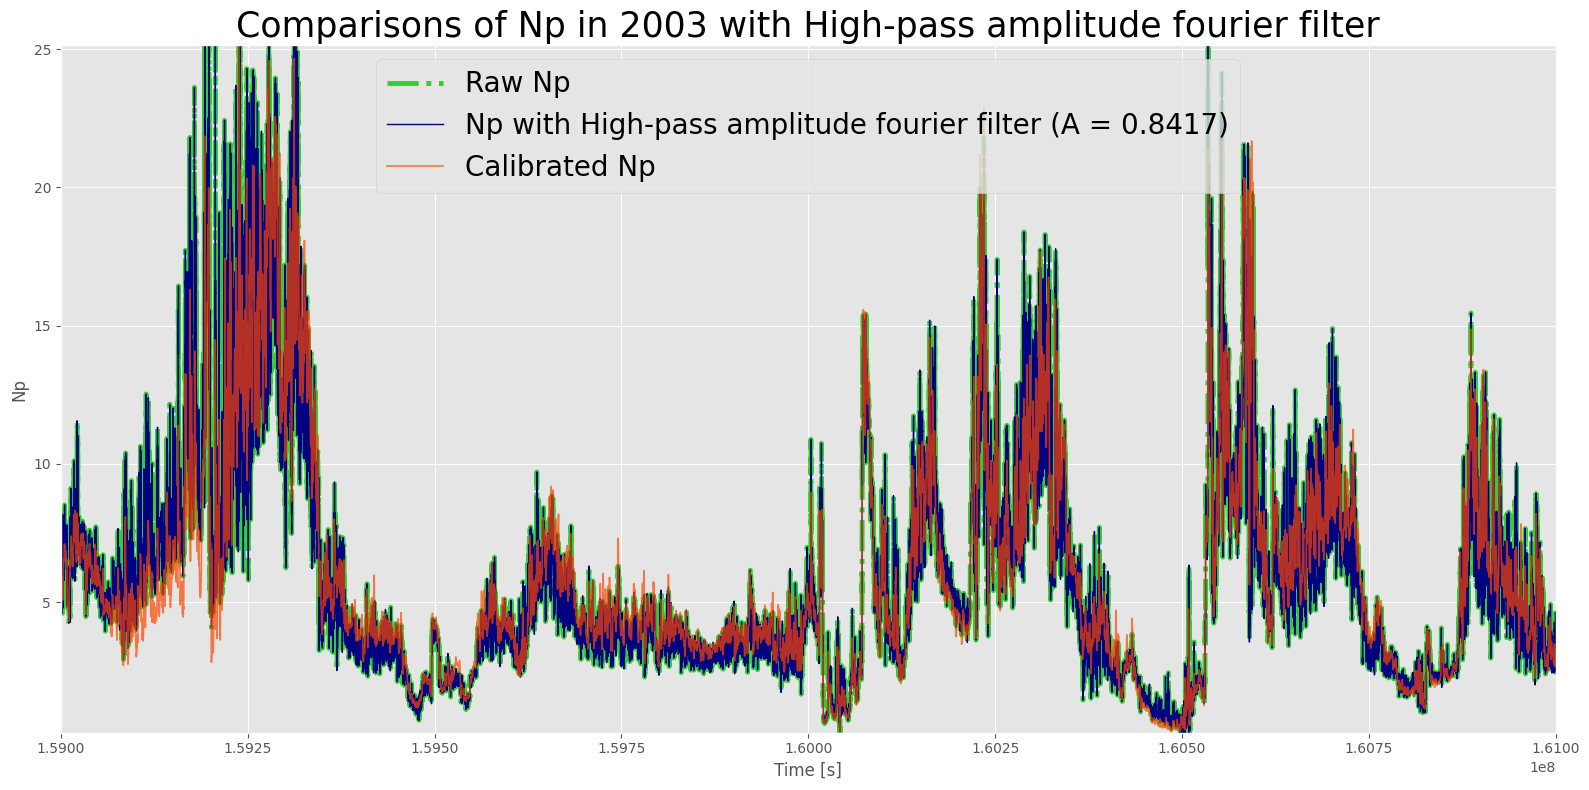

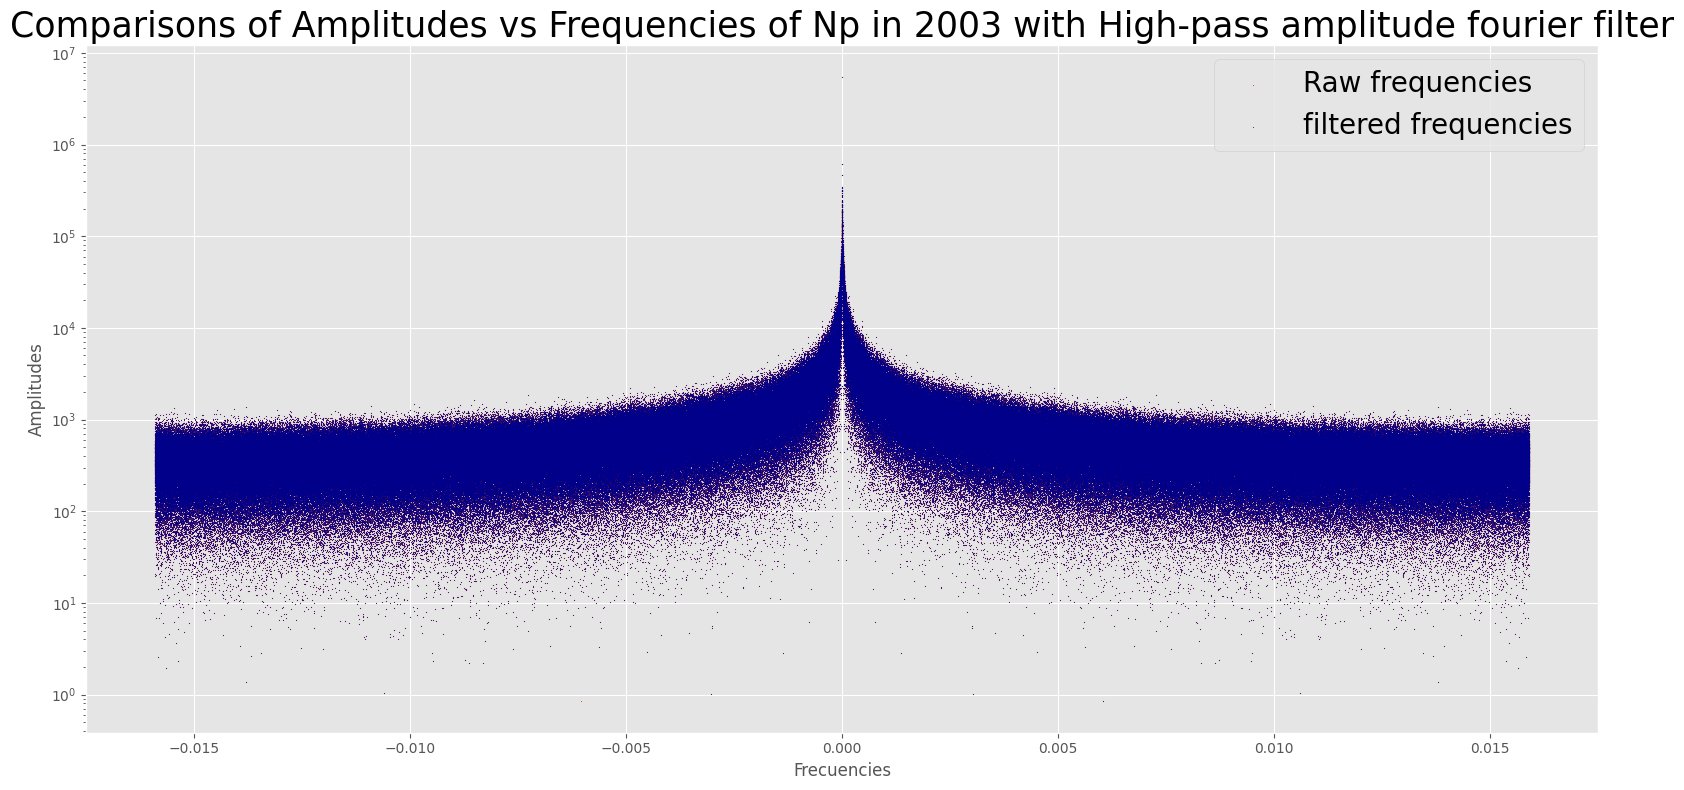

The maximum R^2 is 0.7318901170070233 for 6991.4841640613595 Hz
The minimum MSE is 0.9793272056038211 for 6991.4841640613595 Hz
The minimum MAE is 0.6334264868803213 for 1.3555441882742199 Hz


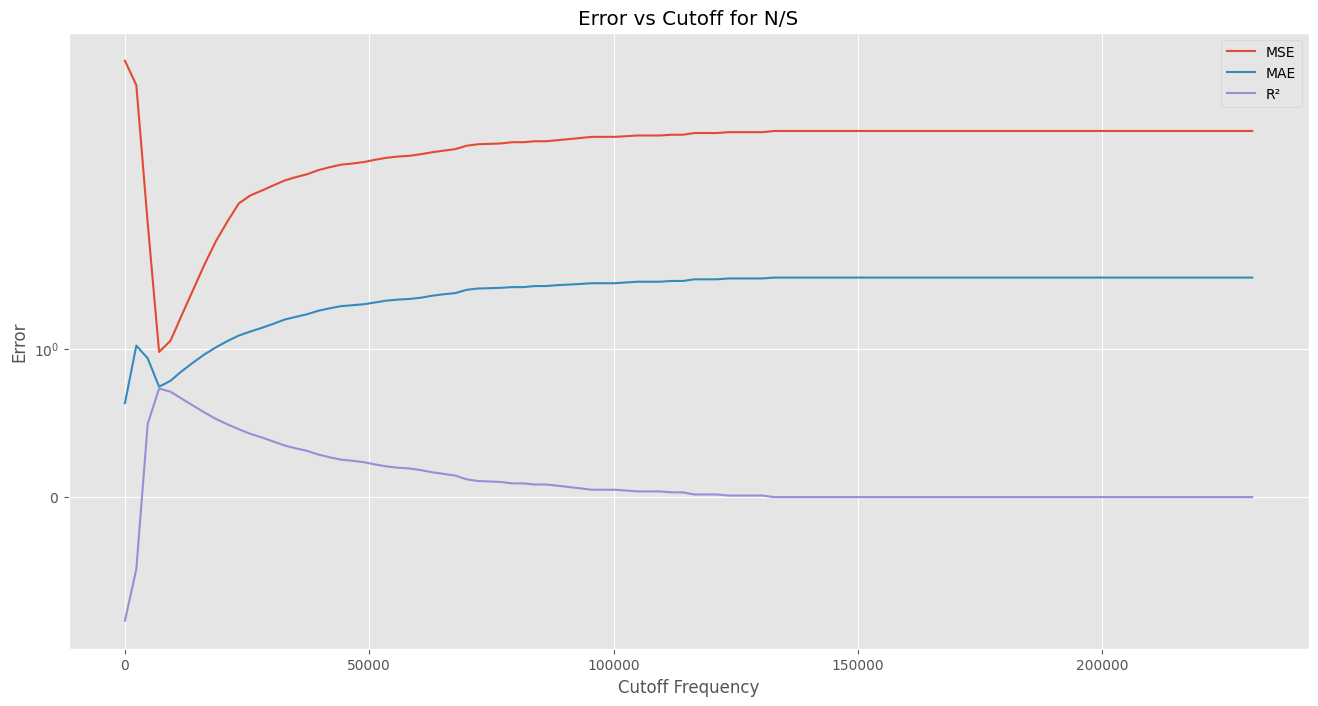

6991.4841640613595


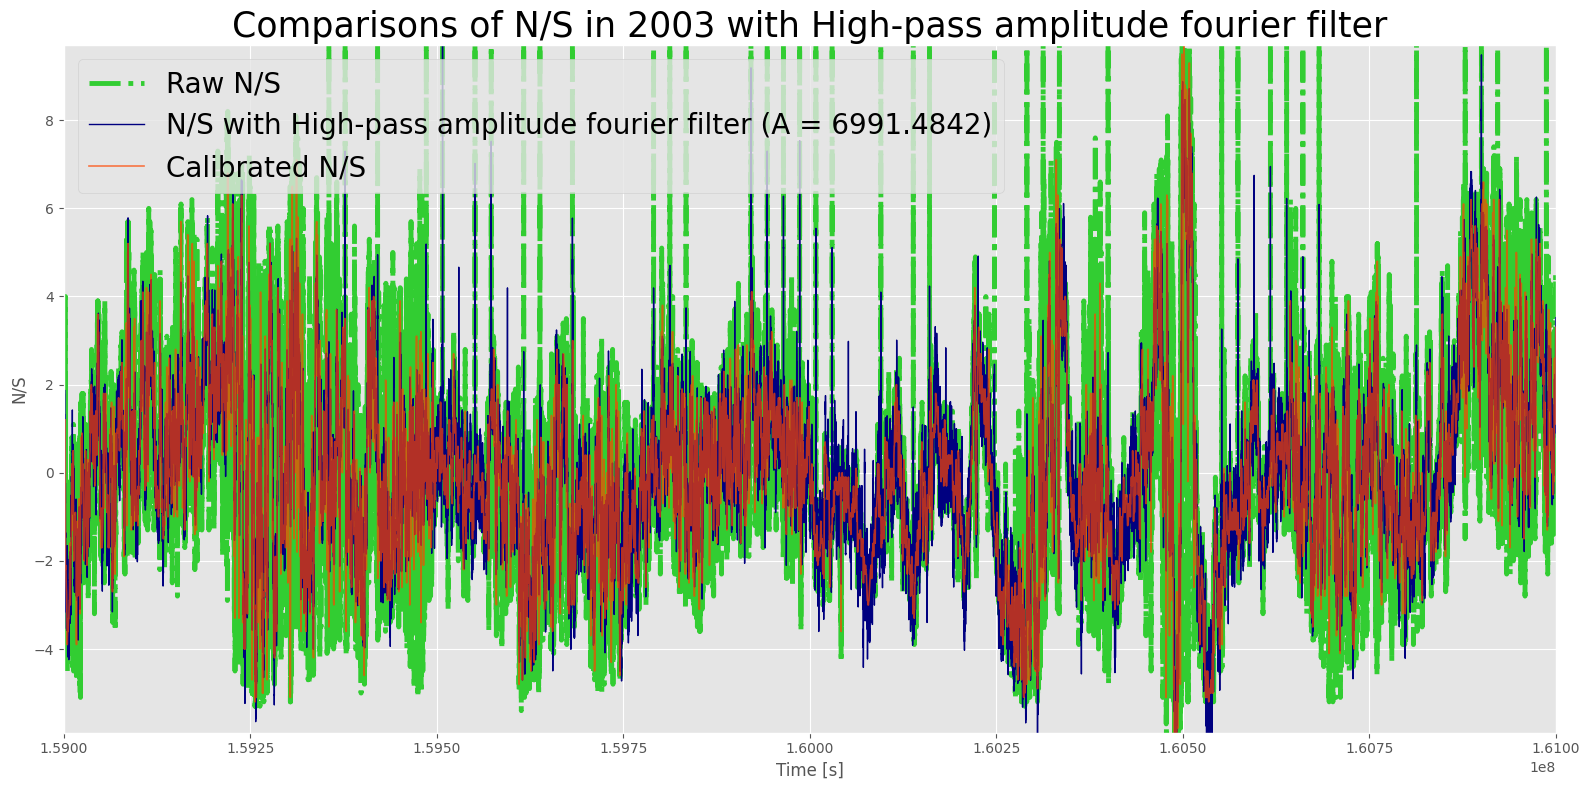

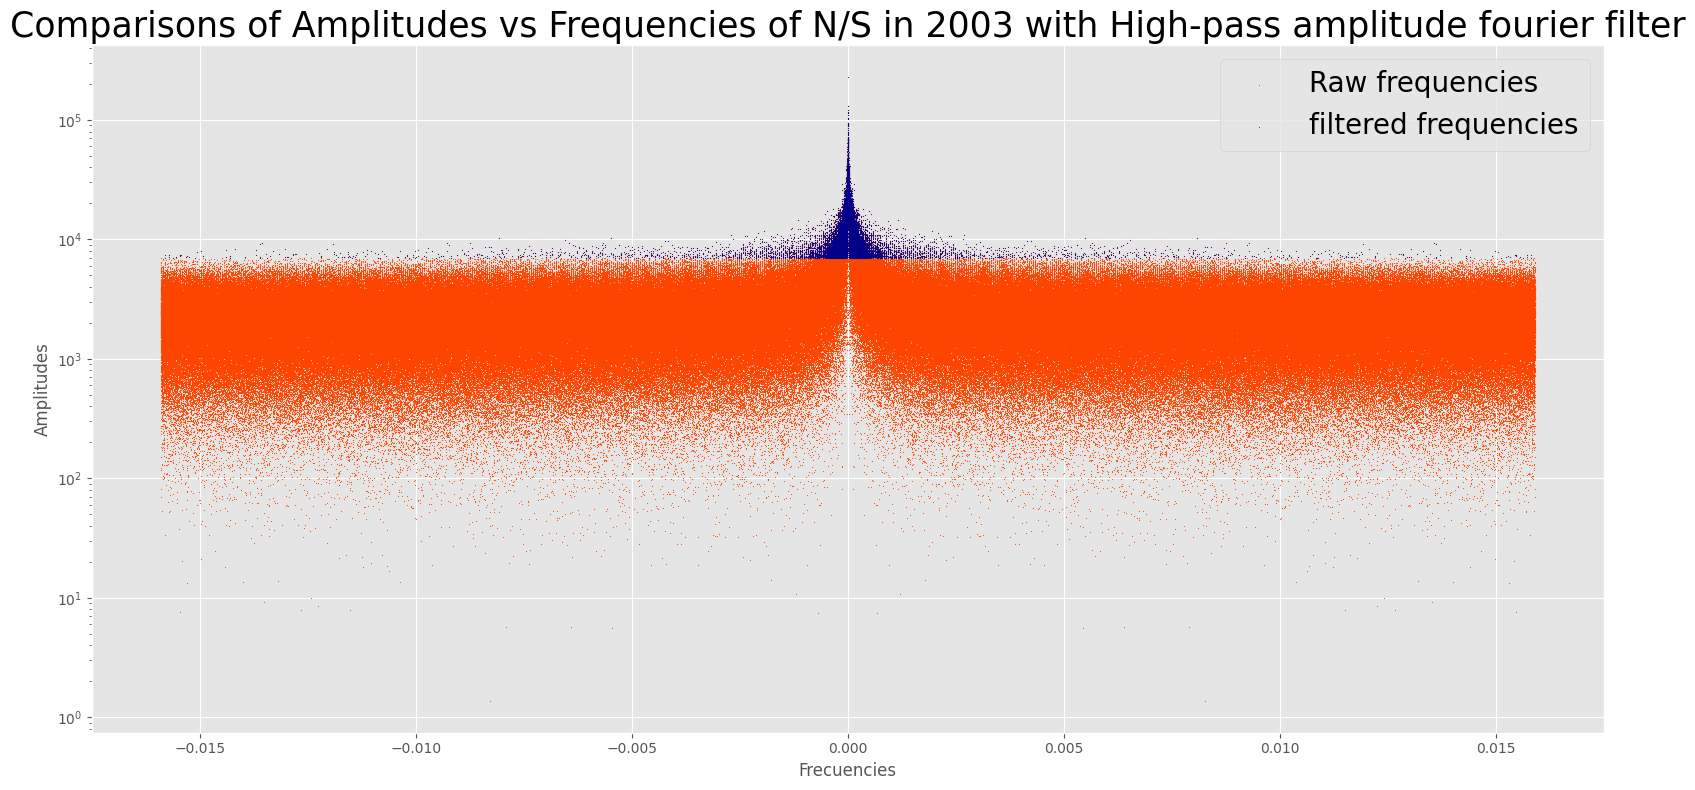

In [49]:

columns = ["SPEED", "Np", "N/S"]

for year in [2003]:
    for column in columns:
        # Calculate the sampling frequency and define the range of cutoff frequencies
        time = Raw_data[year]["Seconds"]
        
        Af = np.sqrt((np.abs(np.fft.fft(Raw_data[year][column]))**2))

        # Define a range of cutoff frequencies to test
        cutoff_frequencies = np.linspace(np.min(Af), np.max(Af), num=100)
        # Find the best cutoff frequency
        optimal_cutoffs = statistics.mode(find_best_cutoff_frequency(year, column, cutoff_frequencies, high_pass_amplitude_fourier_filter))
        print(optimal_cutoffs)
        # Plot the original signal and the filtered signal for each optimal frequency
        plt.figure(figsize=(16, 8))
        plt.plot(Raw_data[year]["Seconds"], Raw_data[year][column], label=f'Raw {column}', color="limegreen", linewidth=3.5, linestyle="-.")
        for A in [optimal_cutoffs]:
            filtered_signal, freqs, fft_signal, filtered_fft_signal = high_pass_amplitude_fourier_filter(Raw_data[year][column], Raw_data[year]["Seconds"], A)
            plt.plot(Raw_data[year]["Seconds"], filtered_signal, label=f'{column} with High-pass amplitude fourier filter (A = {A:.4f})', color="navy", linewidth=1, linestyle="-")
        plt.plot(Calibrated_data[year]["Seconds"], Calibrated_data[year][column], label=f'Calibrated {column}', color="orangered", linewidth=1.2, linestyle="-", alpha=0.7)
        plt.title(f'Comparisons of {column} in {year} with High-pass amplitude fourier filter', fontsize=25)
        plt.xlabel('Time [s]')
        plt.ylabel(column)

        # Valores objetivo
        tmin = 1.59e8 
        tmax = 1.61e8
        # Encuentra los índices de los valores en `x` más cercanos a los objetivos
        idx_t_min = np.argmin(np.abs(Calibrated_data[year]["Seconds"] - tmin))
        idx_t_max = np.argmin(np.abs(Calibrated_data[year]["Seconds"] - tmax))
        # Asegura que index1 sea menor que index2 para definir correctamente el rango
        start_idx, end_idx = sorted((idx_t_min, idx_t_max))
        # Encuentra el mínimo y el máximo en el rango de `z` especificado por `start_index` y `end_index`
        y_min = np.min(Calibrated_data[year][column][start_idx:end_idx + 1])
        y_max = np.max(Calibrated_data[year][column][start_idx:end_idx + 1])

        plt.xlim(tmin, tmax)
        plt.ylim(y_min, y_max)
        plt.legend(fontsize=20)
        plt.tight_layout()
        plt.show()

        # Plot the original signal and the filtered signal for each optimal frequency
        plt.figure(figsize=(16, 8))
        for f in [optimal_cutoffs]:
            filtered_signal, freqs, fft_signal, filtered_fft_signal = high_pass_amplitude_fourier_filter(Raw_data[year][column], Raw_data[year]["Seconds"], f)
            plt.scatter(freqs, np.abs(fft_signal.real), label=f'Raw frequencies', s=1e-1, c="orangered")
            plt.scatter(freqs, np.abs(filtered_fft_signal.real), label=f'filtered frequencies', s=1e-1, alpha=0.75, c="darkblue")
        plt.title(f'Comparisons of Amplitudes vs Frequencies of {column} in {year} with High-pass amplitude fourier filter', fontsize=25)
        plt.xlabel('Frecuencies')
        plt.ylabel("Amplitudes")
        plt.yscale("log")
        plt.legend(fontsize=20)
        plt.tight_layout()
        plt.show()